In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
from scipy.io import loadmat
import pandas as pd

## Loading the Data

We first initialize the paths to the dataset

In [ ]:
url = "http://imagenet.stanford.edu/internal/car196/cars_train"
url_label = "https://ai.stanford.edu/~jkrause/cars/car_devkit"

path = Path('data/cars_train/');
path_label = Path('data/car_devkit/');

To train the plain ResNet50 and VGG19 networks we use the default data augmentations which are  
 - random horizontal flip with the probability of 0.5
 - random rotation of $\phi \in [-10°, +10°]$
 - random zoom of with maximal increase of 10% with the probability of 0.75
 - change of brightness by 20% with the probability of 0.75
 - change of contrast by 20% with the probability of 0.75

In [ ]:
tfms = get_transforms()

Now we load the annotation files create a Data Frame for the training data showing the image name and the acording label (car model)

In [2]:
mat_data = loadmat('data/car_devkit/cars_train_annos.mat')
mat_meta = loadmat('data/car_devkit/cars_meta.mat')

class_id_label = mat_data['annotations']["class"].squeeze()
fname = mat_data['annotations']["fname"].squeeze()
class_names = mat_meta['class_names'].squeeze()

class_id_label_list = [class_id[0][0] for class_id in class_id_label]
fname_list = [f[0] for f in fname]
class_names_list = [c[0] for c in class_names]

class_name_label_list = [class_names_list[idx-1] for idx in class_id_label_list] 

train_df = pd.DataFrame(
    {'fname': fname_list,
     'label': class_name_label_list,
    })

train_df.head()

,fname,label
0,00001.jpg,Audi TTS Coupe 2012
1,00002.jpg,Acura TL Sedan 2012
2,00003.jpg,Dodge Dakota Club Cab 2007
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012


Finally we create the dataset from our training data with a 20% validation split.

In [ ]:
data = (
    ImageList
    .from_df(df=train_df, path=path)
    .split_by_rand_pct(valid_pct=0.2, seed=1010) # Seed to make sure validation set is the same everytime we repeat an experiment
    .label_from_df(cols="label")
    .transform(tfms=tfms, size=448, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
    .databunch(bs=16)
    .normalize(imagenet_stats) # Normalize Image according to ImageNet's Normalization because we are using ImageNet's pretrained model
)

The same has to be done for the test dataset too

In [3]:
test_path = untar_data('http://imagenet.stanford.edu/internal/car196/cars_test')
test_mat_path = download_data(url='http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels', ext=".mat")

mat_test = loadmat(path_label/'cars_test_annos.mat')
mat_test_label = loadmat(test_mat_path)

test_id_label = mat_test_label['annotations']["class"].squeeze()
test_fname = mat_test_label['annotations']["fname"].squeeze()

test_id_label_list = [class_id[0][0] for class_id in test_id_label]
test_fname_list = [f[0] for f in test_fname] 
class_names_list;

test_class_name_label_list = [class_names_list[idx-1] for idx in test_id_label_list] 

test_df = pd.DataFrame(
    {'fname': test_fname_list,
     'label': test_class_name_label_list,
    })


#test_df.head()

In [ ]:
df1 = train_df
df1["is_valid"] = False    # to dindicate what is the test data
df2 = test_df
df2["is_valid"] = True     # to dindicate what is the test data
real_test_df = pd.concat([df1,df2])

In [4]:
real_test_df.head()

,fname,label,is_valid
0,00001.jpg,Audi TTS Coupe 2012,False
1,00002.jpg,Acura TL Sedan 2012,False
2,00003.jpg,Dodge Dakota Club Cab 2007,False
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,False
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,False


In [5]:
test_data = (
    ImageList
    .from_df(df=real_test_df, path=test_path)
    .split_from_df()
    .label_from_df(cols="label")
    .transform(tfms=tfms, size=448, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
    .databunch(bs=16)
    .normalize(imagenet_stats)
)

In the following we will train the ResNet50 and the VGG19

In [6]:
learnVgg = cnn_learner(data, models.vgg19_bn, metrics=[accuracy]).mixup()
learnResnet50 = cnn_learner(data, models.resnet50, metrics=[accuracy]).mixup()

By default the model will first train the fully connected layer and freeze all the layers before. This way we will be able to give the network an understanding about the new dataset. This is advisable to do, since many of the features (e.g. edges, simple shapes) are existent in the most datasets and do not need to be changed as much as the fully connected new layer with random weights.

## Training the models

With the learning rate finder we can visualize the expected steepest slope in the loss for different learning rates

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


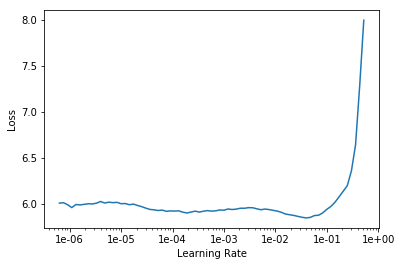

In [18]:
learnVgg.lr_find()
learnVgg.recorder.plot()

We pick a learning rate, wich is not too close to the divergence of the loss, but which is also not too small, to not slow down training. We than use the cyclic learning rate scheduler to train both pretrained models (ResNet50, VGG19) for 15 epochs each

In [8]:
learnVgg.fit_one_cycle(20, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,5.851727,5.406167,0.009828,03:27
1,5.518248,4.995474,0.038084,03:21
2,4.987679,4.373135,0.110565,03:21
3,4.462894,3.660604,0.225430,03:21
4,4.046883,3.046045,0.324939,03:21
5,3.559088,2.483951,0.420147,03:21
6,3.209204,2.119555,0.511671,03:21
7,3.060871,1.853080,0.570639,03:21
8,2.944201,1.677744,0.614865,03:21
9,2.786982,1.560583,0.632064,03:21


In [13]:
#learnVgg.save('vgg19_bn_488_freezed_trained', return_path=True)

PosixPath('data/cars_train/models/vgg19_bn_488_freezed_trained.pth')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


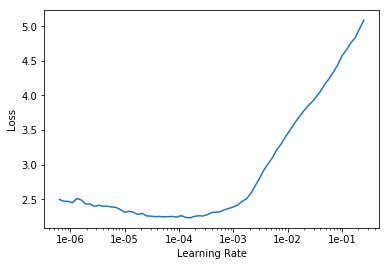

In [16]:
learnVgg.lr_find()
learnVgg.recorder.plot()

Both models seem to converge after nearly 15 epochs. Now we can unfreeze all layers and train everything together and enable the models to recognise more dataset-specific structures.

In [14]:
learnVgg.unfreeze()

We will train the models for 15 epochs with an intervall of learning rates between $[10^{-6}, 10^{-4}]$

In [18]:
learnVgg.fit_one_cycle(15, max_lr=slice(5e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,2.294583,1.145893,0.725430,05:17
1,2.243447,1.079821,0.733415,05:17
2,2.165082,0.996858,0.761671,05:17
3,2.035256,0.924632,0.777027,05:17
4,2.005455,0.877758,0.789312,05:17
5,1.979123,0.804402,0.800983,05:17
6,1.868233,0.770704,0.816339,05:17
7,1.794040,0.732534,0.828010,05:18
8,1.790503,0.696051,0.835995,05:19
9,1.766996,0.679558,0.837224,05:18


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


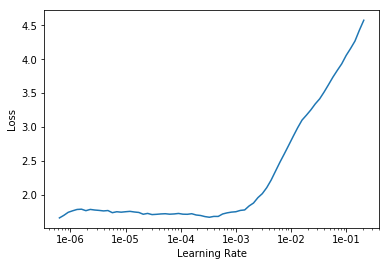

In [20]:
learnVgg.lr_find()
learnVgg.recorder.plot()

In [22]:
learnVgg.fit_one_cycle(5, max_lr=slice(5e-6, 5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.672897,0.700437,0.841523,05:16
1,1.835956,0.721137,0.829853,05:16
2,1.678807,0.646266,0.852580,05:17
3,1.649632,0.601614,0.864865,05:17
4,1.618197,0.580090,0.874079,05:18


The ResNet50 Model seems to stagnete, so we are going to finish training here

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


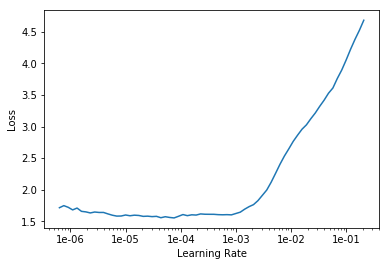

In [23]:
learnVgg.lr_find()
learnVgg.recorder.plot()

In [24]:
learnVgg.fit_one_cycle(5, max_lr=slice(5e-6, 5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.535336,0.627638,0.860565,05:16
1,1.670428,0.627930,0.853808,05:14
2,1.580040,0.580885,0.868550,05:14
3,1.524601,0.536895,0.880835,05:15
4,1.437388,0.532384,0.875307,05:16


it seems as both models have archieved their maximal accuracy

In [31]:
# learnVgg.save('vgg19_bn_488_unfreezed_trained', return_path=True)

PosixPath('data/cars_train/models/vgg19_bn_488_unfreezed_trained.pth')

In [35]:
#torch.save(learnVgg.model, 'models/pretrained/vgg19_bn_488_unfreezed_trained.pth')

In [27]:
learnVgg.validate(test_data.valid_dl)

[0.5023766, tensor(0.8930)]

So we archieve an accuracy 89,3% with the VGG19 Networks

In [7]:
#learnResnet50.load('trained resnet50')
#learnVgg.load('trained vgg19')

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Nissan 240SX Coupe 1998,Audi S5 Convertible 2012,Chevrolet Sonic Sedan 2012,Chevrolet Silverado 1500 Hybrid Crew Cab 2012,Mercedes-Benz S-Class Sedan 2012
Path: data/cars_train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), strid

In [6]:
class Bilinear(nn.Module):
    def __init__(self, fc_in, conv1, conv2):
        super(Bilinear, self).__init__()
        self.f_a = conv1   
        self.f_b = conv2    
        self.fc_in = fc_in
        self.fc = nn.Linear(self.fc_in, 196)
        
    def forward(self, x):
        out_fa = self.f_a(x)
        out_fb = self.f_b(x)
        bs = out_fa.shape[0]
        #print('p1:', out_fb.shape)
        #print('p2:', out_fa.shape)
        pooled_bil = self.bilinearSumpool(A=out_fa, B=out_fb)
        pooled_bil = self.fc(pooled_bil.cuda())
        return pooled_bil

    
    def bilinearSumpool(self, A, B):
        bs, fs, width = A.size(0), A.size(1), A.size(2)
        A = torch.reshape(A, (bs, fs, width * width))
        B = torch.reshape(B, (bs, fs, width * width))
        pooled = torch.bmm(A, torch.transpose(B, 1, 2)).reshape(bs, fs*fs)
        return pooled
    
    
def clear_dataloader(dataloader):

    counter = 0
    new_set = []
    for image in dataloader.dataset.imgs:
        im = torch.tensor(io.imread(image[0]))
        if len(im.shape) < 3 or im.size(2) < 3:
            counter +=1
        else:
            new_set.append(image)
    dataloader.dataset.imgs = new_set
    print(counter, 'elements cleared')
    return dataloader

# res50_model = models.resnet50(pretrained=True)
# res152_model = models.resnet152(pretrained=True)

To cut the ResNet50 and get the feature output of shape $(512\times 28\times 28)$ use  

for FastAi Modules  
`nn.Sequential(*list(list(trainedRes.children())[0].children())[:7], 
              *list(list(list(list(trainedRes.children())[0].children())[7].children())[0].children())[:2])`
To cut the VGG19 and get the feature output of shape $(512\times 28\times 28)$ use  
`nn.Sequential(*list(list(list(trainedVgg.children())[0].children())[0].children())[:-2])`



## Following does not apply on 448:  

Alternatively for the shape $(256\times 56\times 56)$  

for PyTorch Modules  
`nn.Sequential(*list(resnet50.children())[:-5])`

`nn.Sequential(*list(list(vgg19.children())[0])[:-27])`


for FastAi Modules  
`nn.Sequential(*list(list(ResNet50Module.children())[0].children())[:-3])`  

`nn.Sequential(*list(list(list(vgg19.children())[0])[0])[:-27])`

Now we cut our trained models to get their feature representations and initialize our bilinear models

In [7]:
trainedRes = torch.load('models/pretrained/resnet50_488_unfreezed_trained.pth')
trainedVgg = torch.load('models/pretrained/vgg19_bn_488_unfreezed_trained.pth')

cut_trainedRes = nn.Sequential(*list(list(trainedRes.children())[0].children())[:7], 
              *list(list(list(list(trainedRes.children())[0].children())[7].children())[0].children())[:2])
cut_trainedVgg = nn.Sequential(*list(list(list(trainedVgg.children())[0].children())[0].children())[:-2])

bil = Bilinear(512*512, cut_trainedRes, cut_trainedVgg)

We should now change the batchsize of our data to 4 or 8, since the bilinear model is very ram needy

In [8]:
data.batch_size = 8
test_data.batch_size = 8

learner = Learner(data, bil, metrics=[accuracy]).mixup()

learner.split([learner.model.f_a, learner.model.f_b, learner.model.fc])
learner.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.26E-13
Min loss divided by 10: 7.76E-14


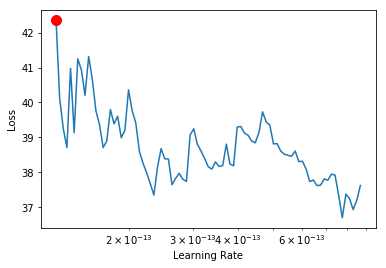

In [21]:
learner.lr_find(start_lr=1e-13, end_lr=1e-12, num_it=100)
learner.recorder.plot(suggestion=True)

In [22]:
min_grad = learner.recorder.min_grad_lr
learner.fit_one_cycle(3, max_lr=min_grad)

epoch,train_loss,valid_loss,accuracy,time
0,39.142982,26.266762,0.783784,05:40
1,38.648605,24.122841,0.798526,05:41
2,38.282631,29.279881,0.784398,05:40


In [9]:
learner.fit_one_cycle(12, max_lr=slice(8e-6))

epoch,train_loss,valid_loss,accuracy,time
0,88.869614,121.240257,0.026413,05:49
1,249.402695,326.883240,0.039926,05:51
2,407.450653,465.293762,0.075553,05:50
3,337.773499,411.255615,0.130221,05:49
4,298.850891,386.576202,0.226658,05:50
5,236.481094,251.483795,0.249386,05:50
6,179.881454,247.155487,0.385749,05:51
7,117.324661,148.412354,0.458231,05:50
8,79.591599,75.396767,0.594595,05:50
9,50.662216,49.007423,0.695946,05:51


In [12]:
learner.fit(1, 3.199e-12)

epoch,train_loss,valid_loss,accuracy,time
0,40.233067,21.929327,0.796069,05:39


In [10]:
learner.save('Bilinear_488_trained_for_12_epochs_lr_8e-6')
torch.save(learner.model, 'models/pretrained/Bilinear_488_trained_for_12_epochs_lr_8e-6.pth')

/home/sipirius/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Bilinear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [13]:
#learner.fit_one_cycle(70, max_lr=slice(1e-7))

epoch,train_loss,valid_loss,accuracy,time
0,39.601349,55.167133,0.008600,05:38
1,43.522530,52.643829,0.021499,05:39
2,51.657436,74.138161,0.071867,05:39
3,66.691269,93.975670,0.110565,05:40
4,84.746185,103.394196,0.139435,05:40
5,94.278587,123.408371,0.164005,05:42
6,110.070541,182.360703,0.180590,05:41
7,113.944572,217.824539,0.209459,05:41
8,116.729935,138.540588,0.295455,05:41
9,111.966560,149.662338,0.321253,05:41


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.24E-08
Min loss divided by 10: 1.20E-08


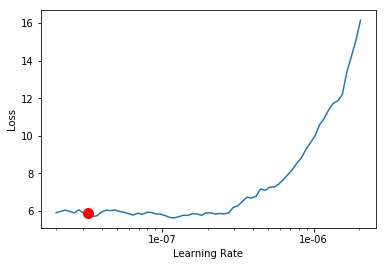

In [13]:
learner.lr_find(start_lr=1e-8 ,num_it=300)
learner.recorder.plot(suggestion=True)

In [11]:
min_grad = learner.recorder.min_grad_lr
learner.fit(1, lr=min_grad)

epoch,train_loss,valid_loss,accuracy,time
0,19.581989,10.995964,0.816339,05:41


In [12]:
learner.validate(test_data.valid_dl)

[9.895448, tensor(0.8306)]

The accuracy on the Training set is $83\%$

In [17]:
learner.fit_one_cycle(10, max_lr=slice(1e-7, 1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,20.855145,16.019566,0.763514,07:38
1,28.323435,19.915268,0.700246,07:39
2,31.646757,25.137297,0.692875,07:39
3,30.323994,26.566805,0.645577,07:40
4,25.360563,22.849201,0.695946,07:40
5,21.876539,32.421375,0.683047,07:40
6,19.195560,16.719353,0.747543,07:41
7,18.527853,10.262352,0.785627,07:42
8,17.861002,11.323819,0.786241,07:42
9,16.298954,10.122717,0.791769,07:42


In [17]:
#learner.save('Bilinear_488_trained_for_30_epochs_lr3e-6')
#torch.save(learner.model, 'models/pretrained/Bilinear_488_trained_for_30_epochs_lr3e-6.pth')